# **Projeção de Reserva/Receita e Expansão do Negócio**


* **Bibliotecas**

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
import statsmodels.api as sm
import folium
import plotly.graph_objs as go

In [292]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
import pmdarima as pm


* **Algumas configurações para o matplotlib**

In [293]:
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(8, 6)

sns.set()

### Importando o conjunto de dados

In [294]:
dados = pd.read_excel('Desafio_DS.xlsx', parse_dates=['Check-in', 'Check-out', 'Reservado'])

## Uma visão inicial do conjunto de dados

* **Tamanho do conjunto de dados**

In [295]:
dados.shape

(5192, 13)

* **São 13 variáveis:**

In [296]:
dados.columns

Index(['Fonte_consolidada', 'Codigo da reserva', 'Nome do Hóspede', 'Status',
       'Nº de pessoas', 'Nº de quartos', 'Check-in', 'Check-out', 'Reservado',
       'Receita bruta estimada', 'Cod_pais', 'Cod_estado', 'Telefone_1'],
      dtype='object')

* **Tipo das variáveis**

In [297]:
dados.dtypes.value_counts()

float64           4
datetime64[ns]    3
int64             3
object            3
dtype: int64

* **Visualizando o conjunto de dados**

In [298]:
#dados.head()

* **Um resumo de cada variável do conjunto de dados**

In [299]:
df_aux = pd.DataFrame({'Type': dados.dtypes,
                      'Missing': dados.isna().sum(),
                      'Size': dados.shape[0],
                       'Unique': dados.nunique()
                     })
df_aux['Missing_%']= df_aux.Missing/df_aux.Size * 100
df_aux.sort_values(by='Missing_%', ascending=False)

,Type,Missing,Size,Unique,Missing_%
Cod_pais,float64,1231,5192,63,23.709553
Cod_estado,float64,1231,5192,204,23.709553
Telefone_1,float64,1196,5192,782,23.035439
Nome do Hóspede,object,107,5192,4569,2.060863
Fonte_consolidada,object,0,5192,2,0.000000
Codigo da reserva,int64,0,5192,5192,0.000000
Status,object,0,5192,2,0.000000
Nº de pessoas,int64,0,5192,7,0.000000
Nº de quartos,int64,0,5192,5,0.000000
Check-in,datetime64[ns],0,5192,307,0.000000


Podemos observar que as variáveis **Cod_pais, Cod_estado, Telefone_1** e  **Nome do Hóspede** estão com valores ausentes. Contudo, a princípio, deixaremos as variáveis **Cod_pais** e **Cod_estado** no conjunto de dados, pois estão abaixo de 50%. 


Apesar das variáveis **Telefone_1** e  **Nome do Hóspede** estarem com valores ausentes abaixo de 50%, iremos descartá-los do conjunto de dados juntamente com a variável **Codigo da reserva** pois resguardam dados pessoais dos clientes. 

* **Removendo variáveis**

In [300]:
dados.drop(columns=['Codigo da reserva','Telefone_1','Nome do Hóspede'], inplace=True)

In [301]:
dados.head()

,Fonte_consolidada,Status,Nº de pessoas,Nº de quartos,Check-in,Check-out,Reservado,Receita bruta estimada,Cod_pais,Cod_estado
0,Site A,Confirmada,1,1,2019-03-10,2019-03-18,2019-02-04,165.50625,55.0,31.0
1,Site A,Confirmada,1,1,2019-03-01,2019-03-16,2019-02-04,382.06875,55.0,551.0
2,Site A,Confirmada,2,1,2019-04-05,2019-04-08,2019-02-04,85.85850,55.0,53.0
3,Site A,Confirmada,2,1,2019-03-01,2019-03-06,2019-02-04,118.65525,57.0,300.0
4,Site A,Confirmada,2,1,2019-04-03,2019-04-07,2019-02-05,108.47025,55.0,11.0


* **Adicionando a variável mês da reserva** 

In [302]:
dados['Mes_reserva'] = dados['Reservado'].dt.month 

# Análise exploratória de dados 

### 1.  Analisando as fontes consolidadas: sites A e B

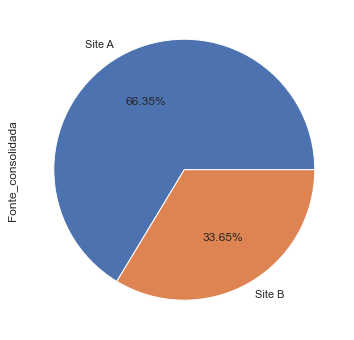

In [303]:
dados['Fonte_consolidada'].value_counts().plot(kind='pie',autopct='%.2f%%');

Podemos observar que a plataforma que dispõe de um maior número de reserva é o site A. 

Com isso podemos investigar alguns possíveis motivos para isto, por exemplo: visibilidade, consolidação no mercado, taxa de serviço e entre outros. 

**Questionamento:** Qual site tem maior
1. visibilidade? 
2. tempo no mercado?
3. taxa de ferramenta?
4. vaga disponível?

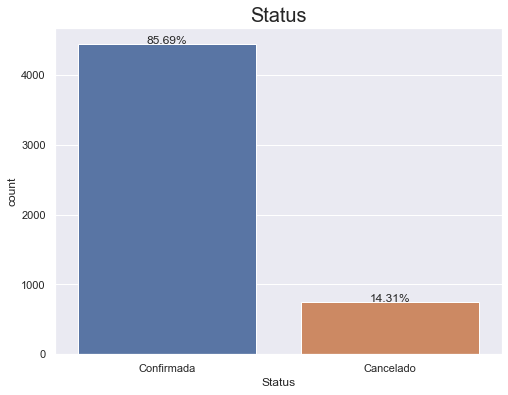

In [304]:
total = len(dados[['Status']])
ax =  sns.countplot(x='Status', data=dados[['Status']])
plt.title('Status', fontsize=20)

for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate('{:.2f}%'.format(100*p.get_height()/total), (x, y), ha='center')
plt.show()

* **Status em geral (reservas com sites A e B)**

Podemos observar que 85.7% confirmaram a reserva de um modo geral. Isto pode ser um indicativo positivo, contudo, vale uma investigação por que 14.3% cancelaram. 


**Questionamento:** Quais os possíveis motivos que levam o cancelamento da reserva? 
1. Será que o site tem influência no cancelamento? Qual dos sites tem maior taxa de cancelamento? Por que? 

* **Status da fonte consolidada por cada site**

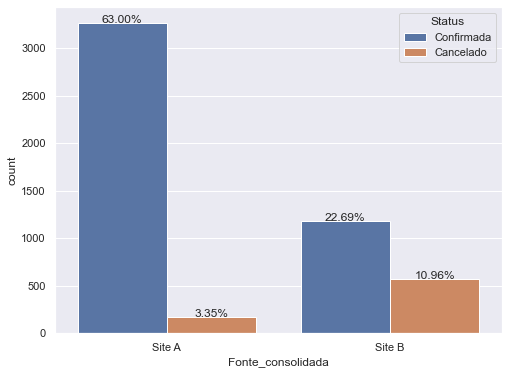

In [305]:
#ax = sns.factorplot('Fonte_consolidada', data=dados, hue='Status', kind='count');
ax = sns.countplot(x='Fonte_consolidada',hue='Status',data=dados)

for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate('{:.2f}%'.format(100*p.get_height()/total), (x, y), ha='center')
plt.show()

Podemos notar um baixo índice de cancelamento do site A. Já do site B por sua vez percebemos um alto valor.  

* *Para melhor entendermos a dimensão do gráfico acima, exibiremos a taxa de confirmação/cancelamento dos sites A e B*

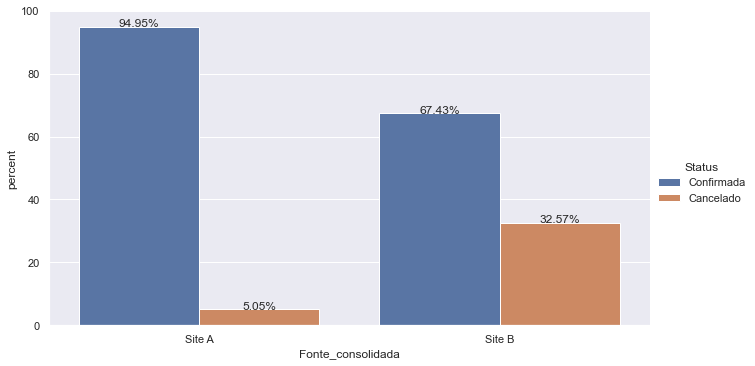

In [306]:
df1 = dados.groupby('Fonte_consolidada')['Status'].value_counts(normalize=True)*100
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x='Fonte_consolidada',y='percent',hue='Status',kind='bar',data=df1, height=5,aspect = 1.8)

g.ax.set_ylim(0,100)
for p in g.ax.patches:
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    g.ax.annotate('{:.2f}%'.format(p.get_height()), (x, y), ha='center')
plt.show()

**Taxa do site A:**

In [307]:
(dados[dados['Fonte_consolidada']=='Site A']['Status'].value_counts(normalize=True)*100).round(2)

Confirmada    94.95
Cancelado      5.05
Name: Status, dtype: float64

**Taxa do site B:**

In [308]:
(dados[dados['Fonte_consolidada']=='Site B']['Status'].value_counts(normalize=True)*100).round(2)

Confirmada    67.43
Cancelado     32.57
Name: Status, dtype: float64

Podemos observar que a taxa de confirmação do **site A** é aprox. 95% e, a taxa de cancelamento é 5%. Que é um indicativo bom (ou muito bom). 

Já o **site B** tem uma taxa de confirmação de 67%. Confirmando que o site B além de ter pouca reserva comparado ao site A existe  uma taxa de cancelamento de aproximadamente 33%, o qual não é um bom indicativo se compararmos com o site A. 

*Com isso podemos concluir que o site B  tem influência na taxa de cancelamento em geral. Deste modo podemos investigar possíveis motivações para isto.*  

* **Agora veremos em qual mês teve maior número de cancelamento**

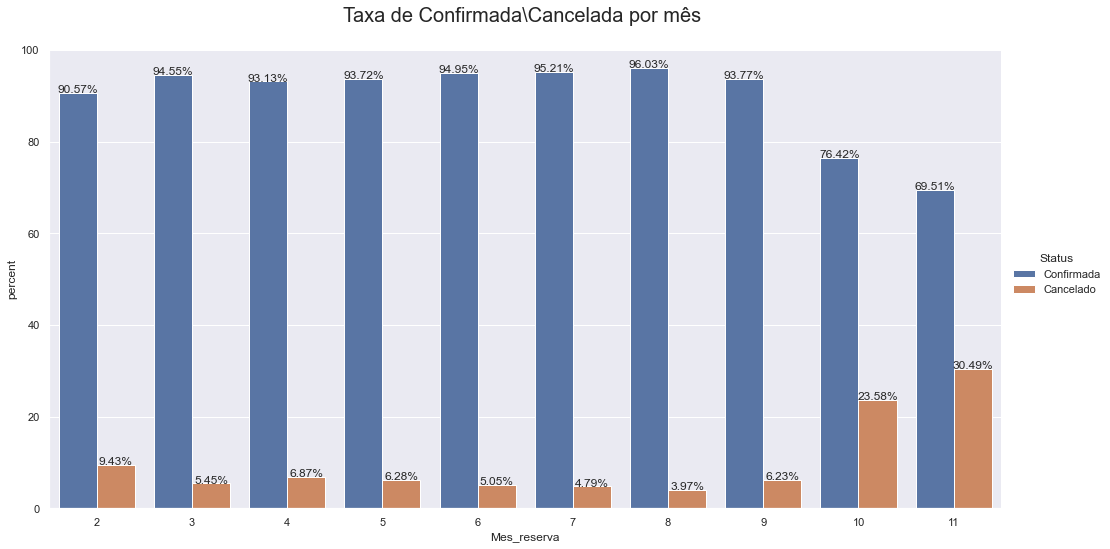

In [309]:
#sns.factorplot('Mes_reserva', data=dados, hue='Status', kind='count');
df1 = dados.groupby('Mes_reserva')['Status'].value_counts(normalize=True)*100
df1 = df1.rename('percent').reset_index()

#g = sns.countplot(x="Mes_reserva", hue="Status", data=df1)
g = sns.catplot(x='Mes_reserva',y='percent',hue='Status',kind='bar',data=df1, height=7,aspect = 2)
g.ax.set_ylim(0,100)
for p in g.ax.patches:
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    g.ax.annotate('{:.2f}%'.format(p.get_height()), (x, y), ha='center')

plt.title('Taxa de Confirmada\Cancelada por mês \n', fontsize=20)
plt.show()

Claramente o mês 11 teve o maior número de cancelamento.  

Uma possível resposta para isto é que no  mês 11 o site B possui um grande  número de reservas (vejamos isso no gráfico abaixo), o que acarreta no alto número de cancelamento. Visto que o site B possui uma alta taxa de cancelamento. 

* **A plataforma que teve maior número de reservas em cada mês** 

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



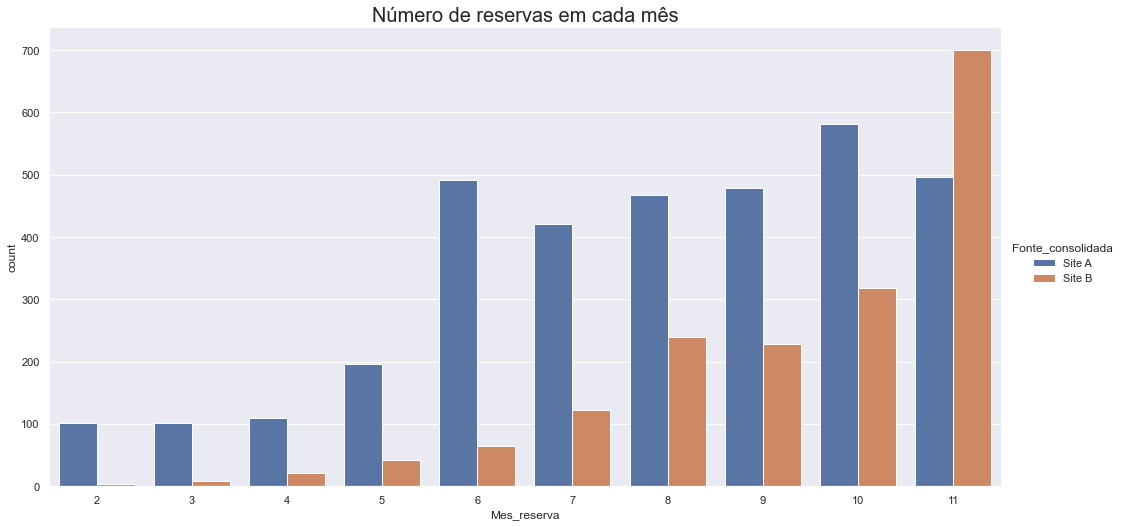

In [310]:
sns.factorplot('Mes_reserva', data=dados, hue='Fonte_consolidada', kind='count',height=7,aspect = 2);
plt.title('Número de reservas em cada mês',fontsize=20)
plt.show()

Podemos notar que os números de reservas do site B aumentaram ao longo dos meses. No entanto, a sua taxa de cancelamento é alta. Caso essa  tendência se mantenha nos próximos 2 meses e, reduzindo a taxa de cancelamento, podemos ter um bom indicativo, já que sua taxa de serviço corresponde a 5% e a do site A  10%.


* Qual o número de cancelamento de cada site em cada mês?


In [311]:
aux_dados = dados[dados['Status']=='Cancelado'][['Fonte_consolidada','Status','Mes_reserva']]
for i in range(2,12):
    print('Mês',i,'\t',aux_dados[aux_dados['Mes_reserva']==i]['Fonte_consolidada'].value_counts())

Mês 2 	 Site A    10
Name: Fonte_consolidada, dtype: int64
Mês 3 	 Site A    6
Name: Fonte_consolidada, dtype: int64
Mês 4 	 Site A    9
Name: Fonte_consolidada, dtype: int64
Mês 5 	 Site A    15
Name: Fonte_consolidada, dtype: int64
Mês 6 	 Site A    24
Site B     4
Name: Fonte_consolidada, dtype: int64
Mês 7 	 Site A    18
Site B     8
Name: Fonte_consolidada, dtype: int64
Mês 8 	 Site A    23
Site B     5
Name: Fonte_consolidada, dtype: int64
Mês 9 	 Site B    28
Site A    16
Name: Fonte_consolidada, dtype: int64
Mês 10 	 Site B    190
Site A     22
Name: Fonte_consolidada, dtype: int64
Mês 11 	 Site B    334
Site A     31
Name: Fonte_consolidada, dtype: int64


In [312]:
aux_df_cofirmada = dados[dados['Status']=='Confirmada'][['Fonte_consolidada','Status','Mes_reserva']]
aux_df_cancelado = dados[dados['Status']=='Cancelado'][['Fonte_consolidada','Status','Mes_reserva']]

In [313]:
siteA_conf = aux_df_cofirmada[aux_df_cofirmada['Mes_reserva']==10]['Fonte_consolidada'].value_counts()[0]
siteA_canc = aux_df_cancelado[aux_df_cancelado['Mes_reserva']==10]['Fonte_consolidada'].value_counts()[1]

siteB_conf = aux_df_cofirmada[aux_df_cofirmada['Mes_reserva']==10]['Fonte_consolidada'].value_counts()[1]
siteB_canc = aux_df_cancelado[aux_df_cancelado['Mes_reserva']==10]['Fonte_consolidada'].value_counts()[0]

In [314]:
print('Taxa de cacelamento mês 10/2019 site A', round(100*(siteA_canc/(siteA_conf+siteA_canc+siteB_conf+siteB_canc)),2))
print('Taxa de cacelamento mês 10/2019 site B', round(100*(siteB_canc/(siteA_conf+siteA_canc+siteB_conf+siteB_canc)),2))

Taxa de cacelamento mês 10/2019 site A 2.45
Taxa de cacelamento mês 10/2019 site B 21.13


In [315]:
siteA_conf = aux_df_cofirmada[aux_df_cofirmada['Mes_reserva']==11]['Fonte_consolidada'].value_counts()[0]
siteA_canc = aux_df_cancelado[aux_df_cancelado['Mes_reserva']==11]['Fonte_consolidada'].value_counts()[1]

siteB_conf = aux_df_cofirmada[aux_df_cofirmada['Mes_reserva']==11]['Fonte_consolidada'].value_counts()[1]
siteB_canc = aux_df_cancelado[aux_df_cancelado['Mes_reserva']==11]['Fonte_consolidada'].value_counts()[0]

In [316]:
print('Taxa de cacelamento mês 11/2019 site A', round(100*(siteA_canc/(siteA_conf+siteA_canc+siteB_conf+siteB_canc)),2))
print('Taxa de cacelamento mês 11/2019 site B', round(100*(siteB_canc/(siteB_conf+siteB_canc+siteA_conf+siteA_canc)),2))

Taxa de cacelamento mês 11/2019 site A 2.59
Taxa de cacelamento mês 11/2019 site B 27.9


* Visualizando os números de cancelamentos de cada site em cada mês

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



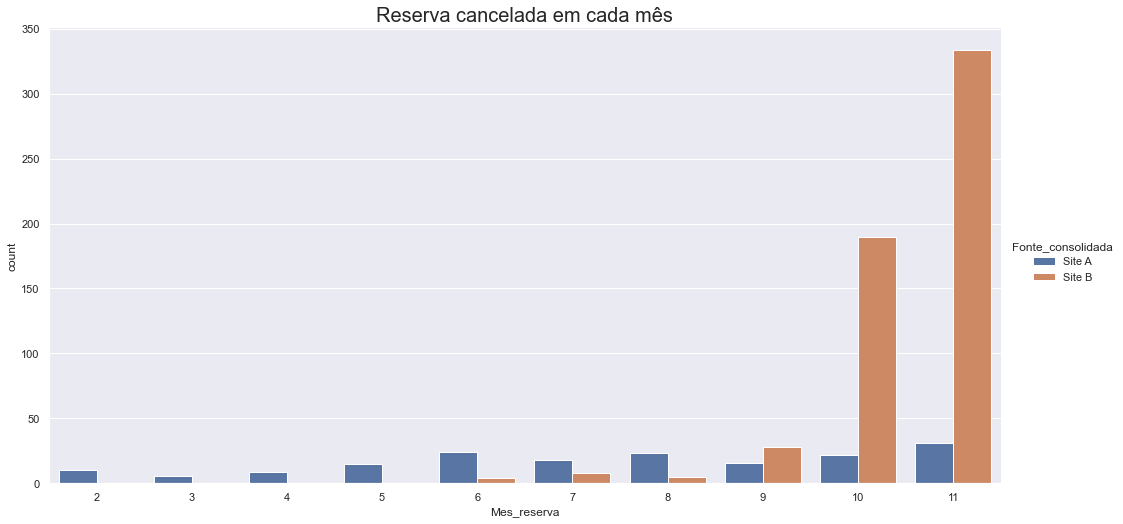

In [317]:
sns.factorplot('Mes_reserva', data=dados[dados['Status']=='Cancelado'][['Fonte_consolidada','Status','Mes_reserva']], hue='Fonte_consolidada', kind='count',height=7,aspect = 2)
plt.title('Reserva cancelada em cada mês',fontsize=20);

* Visualizando os números de confirmação de cada site em cada mês

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

C:\Users\Administrador\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



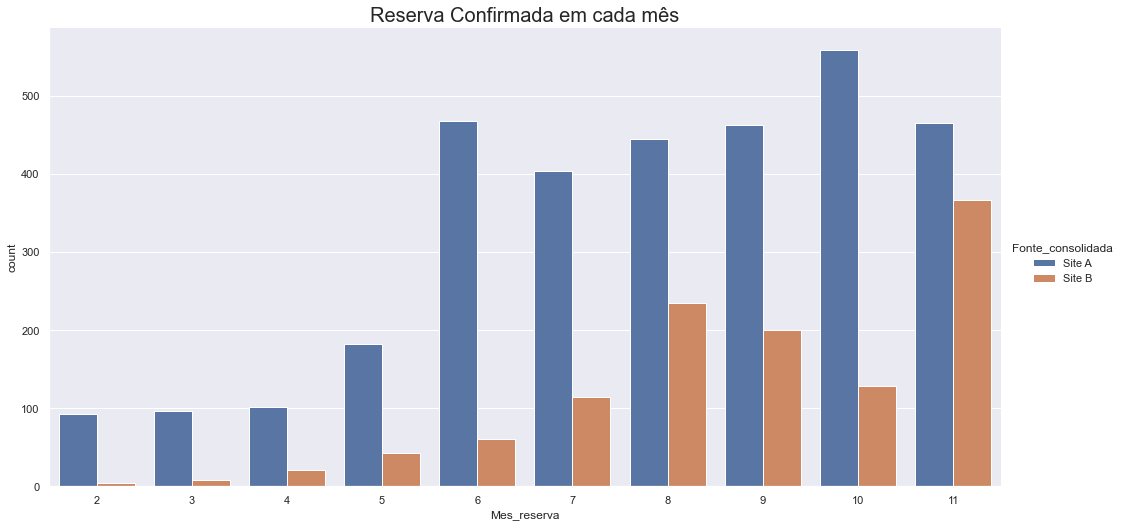

In [318]:
ax=sns.factorplot('Mes_reserva', data=dados[dados['Status']=='Confirmada'][['Fonte_consolidada','Status','Mes_reserva']], hue='Fonte_consolidada', kind='count',height=7,aspect = 2)
plt.title('Reserva Confirmada em cada mês',fontsize=20);

### 2. Analisando a variável Nº de pessoas

* **Visualizando - Nº de pessoas por reserva**

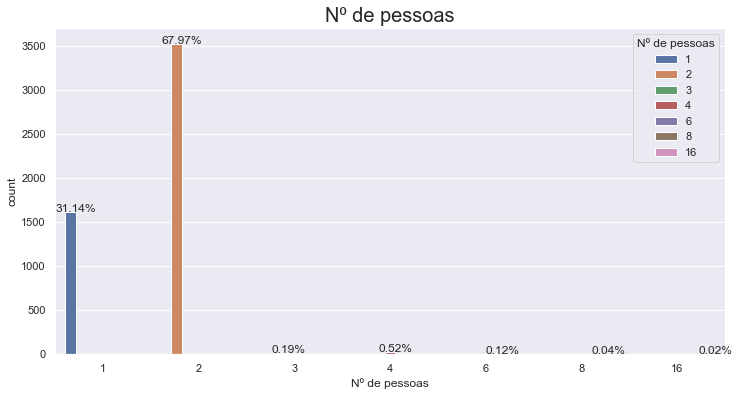

In [319]:
plt.figure(figsize=(12,6))
total = len(dados['Nº de pessoas'])
#ax=dados['Nº de pessoas'].value_counts().plot(kind='bar')
ax =  sns.countplot(x="Nº de pessoas", hue="Nº de pessoas", data=dados[['Nº de pessoas']])
plt.title('Nº de pessoas', fontsize=20)
for p in ax.patches:
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate('{:.2f}%'.format(100 * p.get_height()/total), (x, y),ha='center')
plt.show()

Podemos observar que aprox. 68% das reservas foram solicitadas para 2 pessoas e aprox. 31%  para 1 pessoa. Que equivale uma taxa de 99% das reservas. 

* **Taxa dos Nº de quartos por reserva**

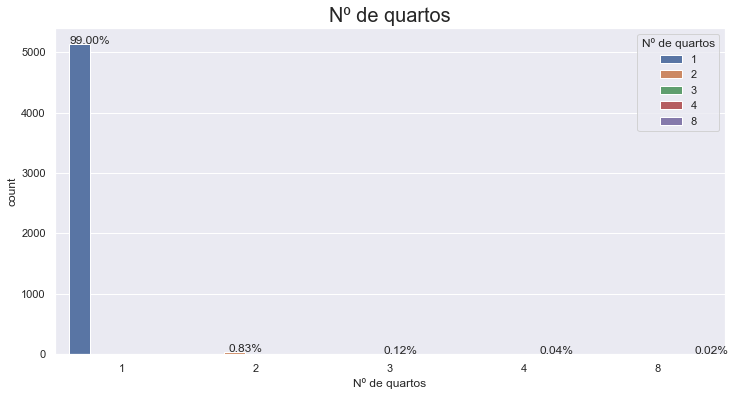

In [320]:
#ax=dados['Nº de quartos'].value_counts().plot.bar();
plt.figure(figsize=(12,6))
total = len(dados['Nº de quartos'])
ax =  sns.countplot(x="Nº de quartos", hue="Nº de quartos", data=dados[['Nº de quartos']])
plt.title('Nº de quartos', fontsize=20)
for p in ax.patches:
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate('{:.2f}%'.format(100 * p.get_height()/total), (x, y),ha='center')
plt.show()

Notemos 99% das reservas foram para 1 quarto.    

### 3. Analisando a variável Código de País

* **Os 10 países com maior número de reservas**

In [321]:
dados['Cod_pais'].value_counts()[:10,]

55.0    3636
1.0       77
33.0      22
44.0      18
54.0      13
51.0      12
56.0      11
57.0      10
61.0      10
49.0      10
Name: Cod_pais, dtype: int64

Podemos notar que o Brasil (Cod_país=55) tem um maior número de reservas 

* *Vamos organizar os códigos dos países como: Brasil (BRA), Não informado (No_INFO) e Exterior ao Brasil (EXT).* 

In [322]:
dados['Cod_pais'].fillna(0,inplace=True) # substituindo zero nos valores ausentes
for i in dados['Cod_pais']:
    if i==55:
        dados['Cod_pais'].replace({i:'BRA'},inplace=True)
    elif i==0:
        dados['Cod_pais'].replace({i:'NO_INFO'},inplace=True)
    else:
        dados['Cod_pais'].replace({i:'EXT'},inplace=True)

* **Taxa de reserva feita por pessoas do Brasil, Não informado e Exterior ao Brasil.**

In [323]:
(dados['Cod_pais'].value_counts(normalize=True)*100).round(2)

BRA        70.03
NO_INFO    23.71
EXT         6.26
Name: Cod_pais, dtype: float64

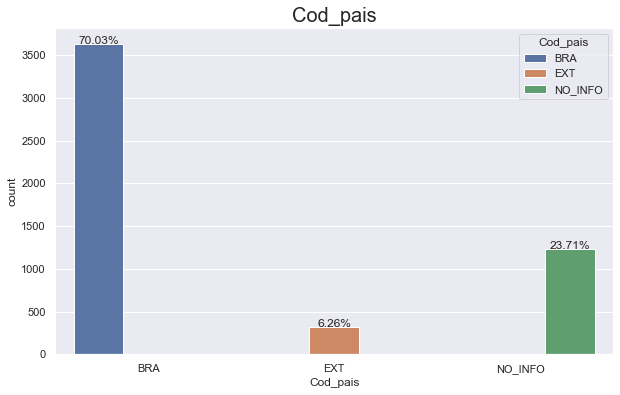

In [324]:
plt.figure(figsize=(10,6))
total = len(dados['Cod_pais'])
ax =  sns.countplot(x="Cod_pais", hue="Cod_pais", data=dados[['Cod_pais']])
plt.title('Cod_pais', fontsize=20)
for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate('{:.2f}%'.format(100 * p.get_height()/total), (x, y), ha='center')
plt.show()

Notemos que de todos os valores do conjunto de dados:
* 70% das reservas são feitas por pessoas que moram no Brasil. 
* 24% não informaram. (Podem morar no Brasil ou não) 
* 6% das reservas feitas são por pessoas que moram no exterior. 

*Note que 24% não informaram onde moram, podendo assim aumentar tanto a taxa das reservas feitas por pessoas que moram no Brasil quanto as feitas por pessoas que moram no exterior.*

### 4. Analisando a variável Códido de Estado 

* **Estados no conjunto de dados**

In [325]:
#Estados brasileiro
EstadoPorDdd = {11:"SP",12:"SP",13:"SP",14:"SP",15:"SP",16:"SP",17:"SP",18:"SP",19:"SP",
                21:"RJ",22:"RJ",24:"RJ",27:"ES",28:"ES",31:"MG",32:"MG",33:"MG",34:"MG",
                35:"MG",37:"MG",38:"MG",41:"PR",42:"PR",43:"PR",44:"PR",45:"PR",46:"PR",
                47:"SC",48:"SC",49:"SC",51:"RS",53:"RS",54:"RS",55:"RS",61:"DF",62:"GO",
                63:"TO",64:"GO",65:"MT",66:"MT",67:"MS",68:"AC",69:"RO",71:"BA",73:"BA",
                74:"BA",75:"BA",77:"BA",79:"SE",81:"PE",82:"AL",83:"PB",84:"RN",85:"CE",
                86:"PI",87:"PE",88:"CE",89:"PI",91:"PA",92:"AM",93:"PA",94:"PA",95:"RR",
                96:"AP",97:"AM",98:"MA",99:"MA" }
dados['Cod_estado'].replace(EstadoPorDdd,inplace=True) 

#Estados não informados
dados['Cod_estado'].fillna(0,inplace=True) # substituindo zero nos valores ausentes
for i in dados['Cod_estado']:
    if i==0:
        dados['Cod_estado'].replace({i:'No_info'},inplace=True)
##Estados exteriores        
for i in dados['Cod_estado']:
    if type(i)==float:
        dados['Cod_estado'].replace({i:'Est_Ext'},inplace=True)    

* **Taxas das reservas dos estados**

*Veremos os 10 estados com maior taxa de reservas*

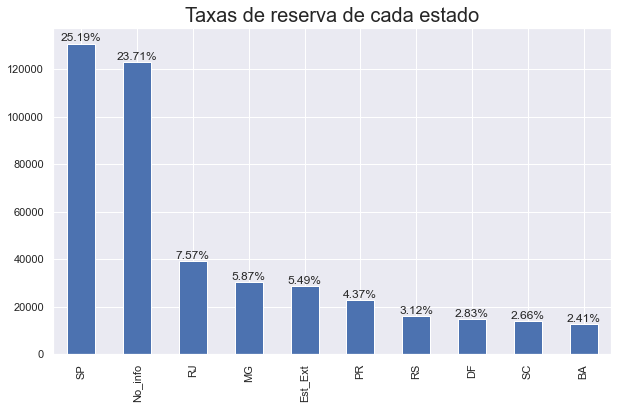

In [326]:
plt.figure(figsize=(10,6))
total = len(dados['Cod_estado'])
ax=(dados['Cod_estado'].value_counts()*100).round(2)[:10].plot.bar(color='b');
plt.title('Taxas de reserva de cada estado', fontsize=20)
for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate('{:.2f}%'.format(p.get_height()/total), (x, y+1000), ha='center')
plt.show()

*Podemos concluir que a procura por reservas está essencialmente em território nacional, mais precisamente nos estados de São Paulo, Rio de Janeiro e Minas Gerais.* 

*Também vale a pena ressaltar o alto número de estados não informados. Talvez conhecendo esses valores poderia ter uma conclusão diferente da vista no gráfico.*   

## Inserindo Latitude e Longitude 

In [327]:
localizador ={'AC': [ -8.77, -70.55], 'AL': [ -9.71, -35.73], 'AM': [ -3.07, -61.66], 'AP': [  1.41, -51.77], 'BA': [-12.96, -38.51]
             ,'CE': [ -3.71, -38.54], 'DF': [-15.83, -47.86], 'ES': [-19.19, -40.34], 'GO': [-16.64, -49.31], 'MA': [ -2.55, -44.30]
             ,'MT': [-12.64, -55.42], 'MS': [-20.51, -54.54], 'MG': [-18.10, -44.38], 'PA': [ -5.53, -52.29], 'PB': [ -7.06, -35.55]
             ,'PR': [-24.89, -51.55], 'PE': [ -8.28, -35.07], 'PI': [ -8.28, -43.68], 'RJ': [-22.84, -43.15], 'RN': [ -5.22, -36.52]
             ,'RO': [-11.22, -62.80], 'RS': [-30.01, -51.22], 'RR': [  1.89, -61.22], 'SC': [-27.33, -49.44], 'SE': [-10.90, -37.07]
             ,'SP': [-23.55, -46.64], 'TO': [-10.25, -48.25]
}
df_L=pd.DataFrame(localizador).transpose()
df_L.columns = ['lat','lng']
df_L.reset_index(inplace=True)
df_L.rename(columns={'index':'Cod_estado'}, inplace= True)

In [328]:
resultado = pd.merge(dados,df_L,on='Cod_estado')

In [329]:
resultado.head(3)

,Fonte_consolidada,Status,Nº de pessoas,Nº de quartos,Check-in,Check-out,Reservado,Receita bruta estimada,Cod_pais,Cod_estado,Mes_reserva,lat,lng
0,Site A,Confirmada,1,1,2019-03-10,2019-03-18,2019-02-04,165.50625,BRA,MG,2,-18.1,-44.38
1,Site A,Confirmada,2,1,2019-03-11,2019-03-14,2019-02-07,89.11875,BRA,MG,2,-18.1,-44.38
2,Site A,Confirmada,2,1,2019-03-22,2019-03-24,2019-02-09,50.92500,BRA,MG,2,-18.1,-44.38


In [330]:
df_status=resultado.groupby('Cod_estado')['Status'].value_counts(normalize=True)

df_status = pd.DataFrame(df_status).rename(columns={'Status':'Count'})
df_status =df_status.pivot_table(values ='Count', index =['Cod_estado'], columns =['Status']) 

In [331]:
df_status = pd.merge(df_status,df_L,on='Cod_estado')
df_status.fillna(0, inplace=True)
df_status.head(3)

,Cod_estado,Cancelado,Confirmada,lat,lng
0,AC,0.333333,0.666667,-8.77,-70.55
1,AL,0.045455,0.954545,-9.71,-35.73
2,AM,0.129870,0.870130,-3.07,-61.66


In [332]:
df_receita=resultado.groupby('Cod_estado')['Receita bruta estimada'].sum()
df_receita.head()

Cod_estado
AC    1117.486125
AL    1620.509625
AM    7328.986875
AP    1158.344250
BA    9548.996625
Name: Receita bruta estimada, dtype: float64

In [333]:
df_receita = pd.merge(df_receita,df_L,on='Cod_estado')
df_receita.head()

,Cod_estado,Receita bruta estimada,lat,lng
0,AC,1117.486125,-8.77,-70.55
1,AL,1620.509625,-9.71,-35.73
2,AM,7328.986875,-3.07,-61.66
3,AP,1158.344250,1.41,-51.77
4,BA,9548.996625,-12.96,-38.51


In [334]:
import plotly.express as px

fig = px.scatter_mapbox(df_receita, lat="lat", lon="lng", hover_name="Cod_estado", hover_data=["Cod_estado"], 
                        color="Receita bruta estimada", size="Receita bruta estimada", 
                        color_continuous_scale=px.colors.sequential.Rainbow, size_max=60,
                        zoom=5, height=1000, mapbox_style="open-street-map")
fig.update_layout(margin={"b":0,"l":0,"t":0,"r":0})

fig.show()

# *Tratamento dos dados em formato de datatimes*

In [335]:
df = dados.drop(columns=['Fonte_consolidada','Nº de pessoas','Nº de quartos','Cod_pais','Cod_estado'])
df.head(5)

,Status,Check-in,Check-out,Reservado,Receita bruta estimada,Mes_reserva
0,Confirmada,2019-03-10,2019-03-18,2019-02-04,165.50625,2
1,Confirmada,2019-03-01,2019-03-16,2019-02-04,382.06875,2
2,Confirmada,2019-04-05,2019-04-08,2019-02-04,85.85850,2
3,Confirmada,2019-03-01,2019-03-06,2019-02-04,118.65525,2
4,Confirmada,2019-04-03,2019-04-07,2019-02-05,108.47025,2


In [336]:
df['Mes_ChechIn']   = df['Check-in'].dt.month 
df['Estadia'] = (df['Check-out']-df['Check-in']).dt.days

In [337]:
df['Check-in'] = df['Check-in'].dt.strftime('%Y-%m')
df['Check-out']= df['Check-out'].dt.strftime('%Y-%m')
df['Reservado']= df['Reservado'].dt.strftime('%Y-%m')
df.head()

,Status,Check-in,Check-out,Reservado,Receita bruta estimada,Mes_reserva,Mes_ChechIn,Estadia
0,Confirmada,2019-03,2019-03,2019-02,165.50625,2,3,8
1,Confirmada,2019-03,2019-03,2019-02,382.06875,2,3,15
2,Confirmada,2019-04,2019-04,2019-02,85.85850,2,4,3
3,Confirmada,2019-03,2019-03,2019-02,118.65525,2,3,5
4,Confirmada,2019-04,2019-04,2019-02,108.47025,2,4,4


Podemos inferir que há uma tendência crescente na série, ou seja, o número de contagem está aumentando em relação ao tempo. 

Além disso é possível notar um crescimento números de reservas feitas a partir do mês 06. 

**Uma hipótese que podemos sustentar é:** No segundo semestre  diversos setores entram em férias. E, portanto, nesse período as reservas são iniciadas a fim de aproveitar melhores os preços, sem ter a preocupação da alta procura dos períodos seguintes.


* **Vamos excluir do conjunto de dados os valores do mês 12.**  

*Para isto, adicionaremos valores nan sobre o número 12 e em seguida droparemos o conjunto de dados.*  

In [338]:
df['Mes_ChechIn'].replace({12:np.nan}, inplace=True) 
df.dropna(inplace=True)

* ### Vamos visualizar os volumes reservado e Check-in mensais

C:\Users\Administrador\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator



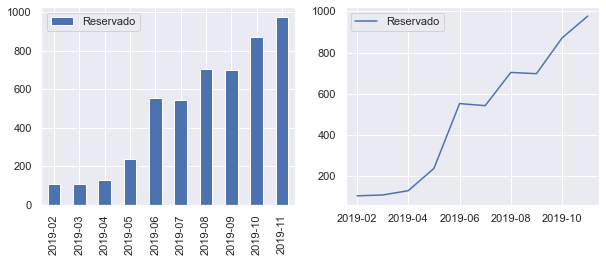

C:\Users\Administrador\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator



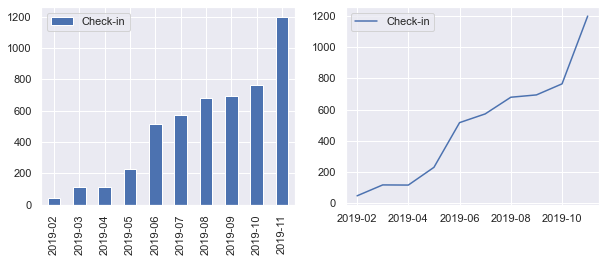

In [339]:
plt.figure(figsize=(10, 8));
plt.subplot(221)
df['Reservado'].value_counts().sort_index().plot(kind='bar',color='b',legend=True);
plt.subplot(222)
df['Reservado'].value_counts().sort_index().plot(legend=True);
plt.show()
plt.figure(figsize=(10, 8));
plt.subplot(221)
df['Check-in'].value_counts().sort_index().plot(kind='bar',color='b',legend=True);
plt.subplot(222)
df['Check-in'].value_counts().sort_index().plot(legend=True);
plt.show()

* ### Vamos excluir do conjunto de dados as reservas com Status Cancelado

 *Já vimos acima que correspondem 14.3% dos dados em geral* 
 
*A decisão desta exclusão se deve principalmente ao fato de não termos  que se preocuparmos com a taxa de cancelamento depois da previsão.*



In [340]:
df = df[df['Status']=='Confirmada']

##### Agora, vamos guardar o volume reservado de cada mês para fazermos a previsão para os próximos 2 meses

In [341]:
cont = df['Reservado'].value_counts().sort_index()
df_cont = pd.DataFrame(cont)
df_cont.columns = ['Count'];

## Aplicando alguns modelos 

Os modelos que serão utilizados para a previsão são:

* **Regressão Linear**
* **Média Móvel**
* **ARMA**
* **ARIMA**

* **Regressão Linear** 

In [342]:
X = [i for i in range(2, len(df_cont)+2)]
X = np.reshape(X, (len(X), 1))
y = df_cont
model_regression = LinearRegression()
model_regression.fit(X, y)

LinearRegression()

*  **Média Móvel**

In [343]:
y_hat_avg = df_cont['Count'].rolling(2).mean()

* **Modelo ARMA**


*Lembrando que o modelo ARMA Refere-se à **Média Móvel AutoRegressiva**: que é uma combinação da equação AR + MA para previsão, onde AR - AutoRegressão e  MA - Média Móvel.*

In [344]:
model_ARMA = sm.tsa.ARMA(df_cont, (3,0)).fit(disp=False);
#Estatistica do modelo
print(model_ARMA.summary());

                              ARMA Model Results                              
Dep. Variable:                  Count   No. Observations:                   10
Model:                     ARMA(3, 0)   Log Likelihood                 -60.820
Method:                       css-mle   S.D. of innovations             93.030
Date:                Mon, 21 Jun 2021   AIC                            131.639
Time:                        23:19:22   BIC                            133.152
Sample:                    02-01-2019   HQIC                           129.980
                         - 11-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         430.0328    107.174      4.012      0.000     219.975     640.090
ar.L1.Count     0.9687      0.227      4.260      0.000       0.523       1.414
ar.L2.Count     0.2836      0.359      0.789    

C:\Users\Administrador\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\Administrador\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



* **Modelo ARIMA**

*Lembrando que o modelo ARIMA: É a **Média Móvel Integrada AutoRegressiva** .*


Além disso: o modelo depende de três variáveis-chave order=(p, d, q), onde:
* p = número de defasagens / ordem dos termos de RA
* d = ordem de diferenciação
* q = número de erros de previsão atrasados ​​/ ordem dos termos de MA

Agora, vamos usar o teste Augmented Dickey Fuller (ADF) ao nível de significância de 5% para verificar se as séries temporais estão estacionárias:

In [345]:
print("p-value:", adfuller(df_cont['Count'])[1])

p-value: 0.0


O p-valor é maior que o nível de significância 0,05, portanto, não é estacionário e a diferenciação é, como tal, necessária, ie. d > 0.

Agora vamos descobrir a ordem da diferenciação, d , usando a correlação automática:

In [346]:
model = auto_arima(df_cont['Count'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=4,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # não queremos saber se um pedido não funciona
                          suppress_warnings=True,  # não queremos avisos de convergência
                          stepwise=True)           # definido como passo a passo

model.summary()

Fit ARIMA: order=(0, 0, 0); AIC=142.471, BIC=143.076, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0); AIC=131.371, BIC=132.279, Fit time=0.098 seconds
Fit ARIMA: order=(0, 0, 1); AIC=137.845, BIC=138.753, Fit time=0.014 seconds
Fit ARIMA: order=(2, 0, 0); AIC=132.762, BIC=133.972, Fit time=0.111 seconds
Fit ARIMA: order=(1, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.236 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                     ARMA(1, 0)   Log Likelihood                 -62.685
Method:                       css-mle   S.D. of innovations            117.529
Date:                Mon, 21 Jun 2021   AIC                            131.371
Time:                        23:19:24   BIC                            132.279
Sample:                             0   HQIC                           130.375
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        402.6800    222.020      1.814      0.070     -32.471     837.831
ar.L1.y        0.8997      0.114      7.893      0.000       0.676       1.123
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1114           +0.0000j            1.1114            0.0000
-----------------------------------------------------------------------------
"""

Order = (1,0,0) 

* p = 1 -  número de defasagens / ordem dos termos de RA
* d = 0 -  ordem de diferenciação 
* q = 0 -  número de erros de previsão atrasados ​​/ ordem dos termos de MA


In [347]:
model_ARIMA = ARIMA(df_cont, order=(1, 0, 0)).fit();
print(model_ARIMA.summary());

                              ARMA Model Results                              
Dep. Variable:                  Count   No. Observations:                   10
Model:                     ARMA(1, 0)   Log Likelihood                 -62.685
Method:                       css-mle   S.D. of innovations            117.529
Date:                Mon, 21 Jun 2021   AIC                            131.371
Time:                        23:19:25   BIC                            132.279
Sample:                    02-01-2019   HQIC                           130.375
                         - 11-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         402.6800    222.020      1.814      0.070     -32.471     837.831
ar.L1.Count     0.8997      0.114      7.893      0.000       0.676       1.123
                                    Roots       

C:\Users\Administrador\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\Administrador\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



* **Calculando RMSE (Root Mean Squared Error) de cada modelo**

In [348]:
print('\nRoot Mean Squared Error')
print('RMSE Regressão Linear:', sqrt(mean_squared_error(df_cont,model_regression.predict(X))))
print('RMSE Média Móvel:', sqrt(mean_squared_error(df_cont.iloc[1:,],y_hat_avg[1:])))
print('RMSE ARMA:', sqrt(mean_squared_error(df_cont, model_ARMA.predict())))
print('RMSE ARIMA:',sqrt(mean_squared_error(df_cont.iloc[:,:], model_ARIMA.predict(typ = 'levels'))))


Root Mean Squared Error
RMSE Regressão Linear: 85.63057369605292
RMSE Média Móvel: 59.96573095434499
RMSE ARMA: 134.51584285544783
RMSE ARIMA: 146.37942205615806


* **Visualizando cada modelo**

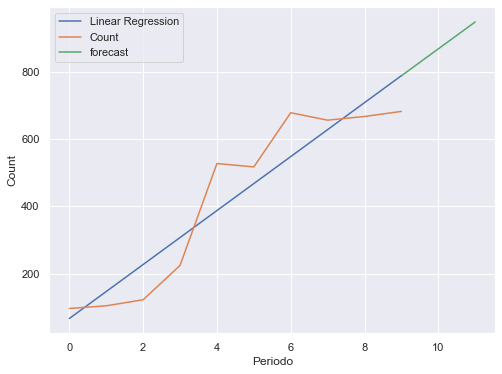

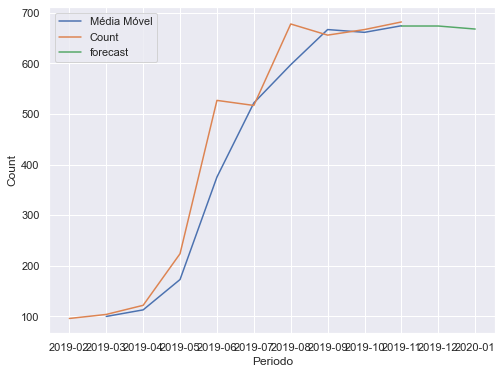

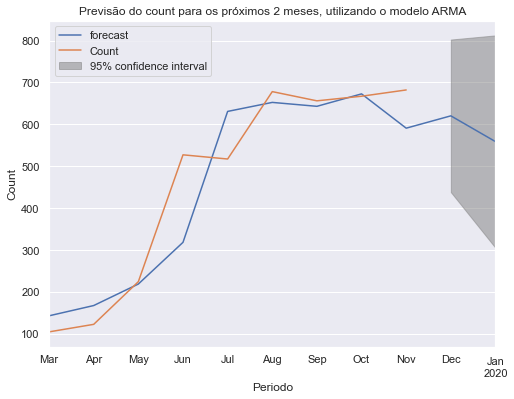

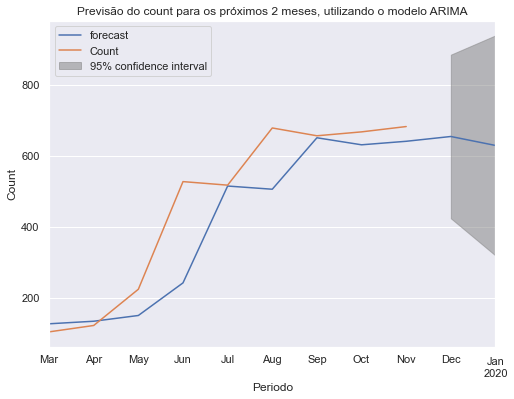

In [349]:
#Regressão Linear
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(model_regression.predict(X), label='Linear Regression' )
plt.plot(df_cont.values,label='Count')
plt.plot([9,10,11],[int(model_regression.predict(np.array([11]).reshape(-1,1))),int(model_regression.predict(np.array([12]).reshape(-1,1))),
                 int(model_regression.predict(np.array([13]).reshape(-1,1)))],label='forecast')
#plt.title('Regressão do Periodo por Count')
plt.xlabel('Periodo')
plt.ylabel('Count')
plt.legend()
plt.show()
#Média móvel
plt.figure(figsize=(8,6)) 
plt.plot(y_hat_avg, label='Média Móvel')
plt.plot(df_cont['Count'], label='Count') 
plt.plot(['2019-11','2019-12','2020-01'],[int(y_hat_avg[-1]),int(y_hat_avg[-1]),int((y_hat_avg[-2]+y_hat_avg[-1])/2)],label='forecast')

plt.ylabel('Count')
plt.xlabel('Periodo')
plt.legend()
plt.show()
#ARMA
fig, ax = plt.subplots(figsize=(8,6))
fig = model_ARMA.plot_predict(start='2019-03', end='2020-01', ax=ax)
plt.title('Previsão do count para os próximos 2 meses, utilizando o modelo ARMA')
plt.ylabel('Count')
plt.xlabel('Periodo')
legend = ax.legend(loc='upper left')
plt.show()
#ARIMA
fig, ax = plt.subplots(figsize=(8,6))
fig = model_ARIMA.plot_predict(start='2019-03', end='2020-01', ax=ax)
plt.title('Previsão do count para os próximos 2 meses, utilizando o modelo ARIMA')
plt.ylabel('Count')
plt.xlabel('Periodo')
legend = ax.legend(loc='upper left')
plt.show()



In [350]:
forecast = {'Mes':['12-2019','01-2020'], 
            'reg_linear':[int(model_regression.predict(np.array([12]).reshape(-1,1))),int(model_regression.predict(np.array([13]).reshape(-1,1)))],
            'media_movel':[int(y_hat_avg[-1]),int((y_hat_avg[-2]+y_hat_avg[-1])/2)],
            'ARMA':model_ARMA.predict(start='2019-12',end='2020-01').values.astype(int),
            'ARIMA':model_ARIMA.predict(start='2019-12',end='2020-01',typ='levels').values.astype(int)}

In [351]:
foracasts = pd.DataFrame(forecast)
foracasts.index=['2019-12','2020-01']

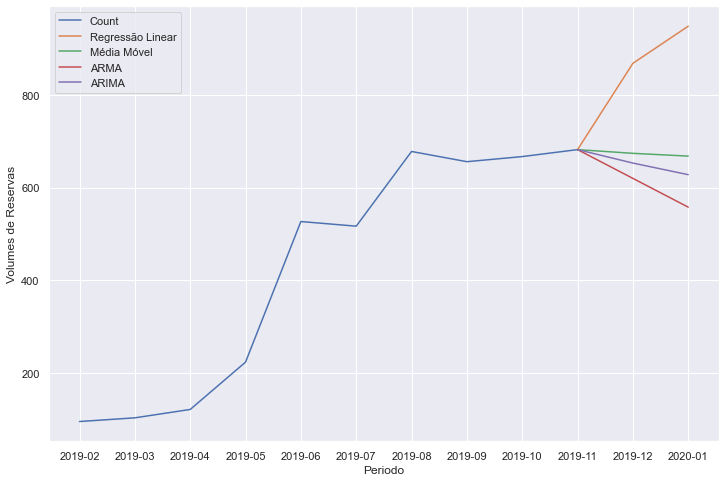

In [352]:
ind = ['2019-11','2019-12','2020-01']
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(df_cont['Count'], label='Count') 
plt.plot(ind,[df_cont['Count'][-1],foracasts['reg_linear'][0],foracasts['reg_linear'][1]],label='Regressão Linear')
plt.plot(ind,[df_cont['Count'][-1],foracasts['media_movel'][0],foracasts['media_movel'][1]],label = 'Média Móvel')
plt.plot(ind,[df_cont['Count'][-1],foracasts['ARMA'][0],foracasts['ARMA'][1]], label = 'ARMA' )
plt.plot(ind,[df_cont['Count'][-1],foracasts['ARIMA'][0],foracasts['ARIMA'][1]], label = 'ARIMA')
plt.ylabel('Volumes de Reservas')
plt.xlabel('Periodo')
legend = ax.legend(loc='upper left')
plt.show()

## Premissas da planilha

* *Custo operacional por unidade em Junho/2019*

In [353]:
def c_op_u():
    pessoal        = 150.0
    manutecao      = 15.0
    lavandeira     = 30.0
    dispersas_fixas= 450.0
    return (pessoal+manutecao+lavandeira+dispersas_fixas)

* **Unidades disponíveis e Taxa de crescimento do custo por unidade**

In [354]:
idx = ['2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11']
Unid_disp = [10,11,17,22,54,59,91,92,92,138]
Taxa_cres_do_cust_por_unid = ['-',-0.05,-0.02,-0.03,-0.10,-0.05,-0.05,-0.01,-0.02,-0.15]
premissas = pd.DataFrame({'Unidades disponíveis':Unid_disp,
              'Taxa de crescimento do custo por unidade':Taxa_cres_do_cust_por_unid},
              index=idx)
premissas

,Unidades disponíveis,Taxa de crescimento do custo por unidade
2019-02,10,-
2019-03,11,-0.05
2019-04,17,-0.02
2019-05,22,-0.03
2019-06,54,-0.1
2019-07,59,-0.05
2019-08,91,-0.05
2019-09,92,-0.01
2019-10,92,-0.02
2019-11,138,-0.15


Agora, vamos calcular **Custo operacional por unidade** de cada mês a partir das seguintes premissas: 
1. *Custo operacional por unidade em Junho/2019*
2. *Taxa de crescimento do custo por unidade* 

In [355]:
Custo_oper_por_unid = [c_op_u()*(1.10)*(1.03)*(1.02)*(1.05),c_op_u()*(1.10)*(1.03)*(1.02),c_op_u()*(1.10)*(1.03),
                       c_op_u()*(1.10),c_op_u(),c_op_u()*(0.95),c_op_u()*(0.95)*(0.95),c_op_u()*(0.95)*(0.95)*(0.99),
                       c_op_u()*(0.95)*(0.95)*(0.99)*(0.98),c_op_u()*(0.95)*(0.95)*(0.99)*(0.98)*(0.85)]
premissas['Custo operacional por unidade'] = Custo_oper_por_unid
premissas

,Unidades disponíveis,Taxa de crescimento do custo por unidade,Custo operacional por unidade
2019-02,10,-,782.670735
2019-03,11,-0.05,745.400700
2019-04,17,-0.02,730.785000
2019-05,22,-0.03,709.500000
2019-06,54,-0.1,645.000000
2019-07,59,-0.05,612.750000
2019-08,91,-0.05,582.112500
2019-09,92,-0.01,576.291375
2019-10,92,-0.02,564.765547
2019-11,138,-0.15,480.050715


* Veremos o custo operacional  por unidade no decorrer dos meses

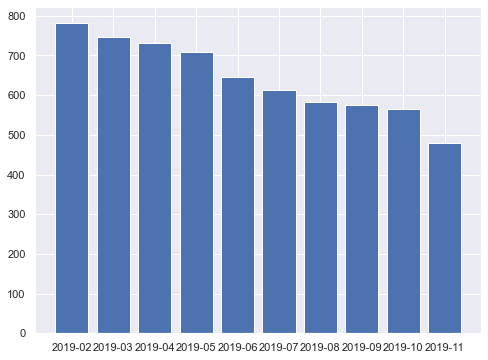

In [356]:
plt.figure(figsize=(8,6)) 
plt.bar(premissas.index,premissas['Custo operacional por unidade']);

Note que o custo por unidade diminui na medida que aumenta o número de unidade disponível.  


* **Agora, veremos uma função que determina a estadia disponível de cada mês diante das unidades disponíveis.** 

In [357]:
def estadia_disponivel(n_unidade,mes):
    if mes==2:
        return n_unidade*28
    if mes==1 or mes==3 or mes==5 or mes==7 or mes==8 or mes==10 or mes==12:
        return n_unidade*31
    if mes==4 or mes==6 or mes==9 or mes==11:
        return n_unidade*30       

* **Adicionando a estadia disponível para cada mês - dados fornecidos das premissas**

In [358]:
Estadia_disponivel = [estadia_disponivel(10,2),estadia_disponivel(11,3),estadia_disponivel(17,4),estadia_disponivel(22,5),
                           estadia_disponivel(54,6),estadia_disponivel(59,7),estadia_disponivel(91,8),estadia_disponivel(92,9),
                           estadia_disponivel(92,10),estadia_disponivel(138,11)]
premissas['Estadia disponível']= Estadia_disponivel
premissas

,Unidades disponíveis,Taxa de crescimento do custo por unidade,Custo operacional por unidade,Estadia disponível
2019-02,10,-,782.670735,280
2019-03,11,-0.05,745.400700,341
2019-04,17,-0.02,730.785000,510
2019-05,22,-0.03,709.500000,682
2019-06,54,-0.1,645.000000,1620
2019-07,59,-0.05,612.750000,1829
2019-08,91,-0.05,582.112500,2821
2019-09,92,-0.01,576.291375,2760
2019-10,92,-0.02,564.765547,2852
2019-11,138,-0.15,480.050715,4140


* **Agora, adicionaremos a estadia ocupada de cada mês**  

In [359]:
Estadia_ocupada = [df[df['Check-in'] == '2019-02']['Estadia'].sum(),df[df['Check-in'] == '2019-03']['Estadia'].sum(),
                  df[df['Check-in'] == '2019-04']['Estadia'].sum(),df[df['Check-in'] == '2019-05']['Estadia'].sum(),
                  df[df['Check-in'] == '2019-06']['Estadia'].sum(),df[df['Check-in'] == '2019-07']['Estadia'].sum(),
                  df[df['Check-in'] == '2019-08']['Estadia'].sum(),df[df['Check-in'] == '2019-09']['Estadia'].sum(),
                  df[df['Check-in'] == '2019-10']['Estadia'].sum(),df[df['Check-in'] == '2019-11']['Estadia'].sum()]
Estadia_ocupada

[116, 308, 344, 552, 1371, 1534, 1785, 2112, 1739, 2262]

In [360]:
premissas['Ocupação'] = Estadia_ocupada
premissas

,Unidades disponíveis,Taxa de crescimento do custo por unidade,Custo operacional por unidade,Estadia disponível,Ocupação
2019-02,10,-,782.670735,280,116
2019-03,11,-0.05,745.400700,341,308
2019-04,17,-0.02,730.785000,510,344
2019-05,22,-0.03,709.500000,682,552
2019-06,54,-0.1,645.000000,1620,1371
2019-07,59,-0.05,612.750000,1829,1534
2019-08,91,-0.05,582.112500,2821,1785
2019-09,92,-0.01,576.291375,2760,2112
2019-10,92,-0.02,564.765547,2852,1739
2019-11,138,-0.15,480.050715,4140,2262


* **Adicionando a Taxa de ocupação**

In [361]:
premissas['Taxa de Ocupação %'] = ((premissas['Ocupação']/premissas['Estadia disponível'])*100).round(2)
premissas

,Unidades disponíveis,Taxa de crescimento do custo por unidade,Custo operacional por unidade,Estadia disponível,Ocupação,Taxa de Ocupação %
2019-02,10,-,782.670735,280,116,41.43
2019-03,11,-0.05,745.400700,341,308,90.32
2019-04,17,-0.02,730.785000,510,344,67.45
2019-05,22,-0.03,709.500000,682,552,80.94
2019-06,54,-0.1,645.000000,1620,1371,84.63
2019-07,59,-0.05,612.750000,1829,1534,83.87
2019-08,91,-0.05,582.112500,2821,1785,63.28
2019-09,92,-0.01,576.291375,2760,2112,76.52
2019-10,92,-0.02,564.765547,2852,1739,60.97
2019-11,138,-0.15,480.050715,4140,2262,54.64


* **Visualizando a estadia disponível e a ocupação** 

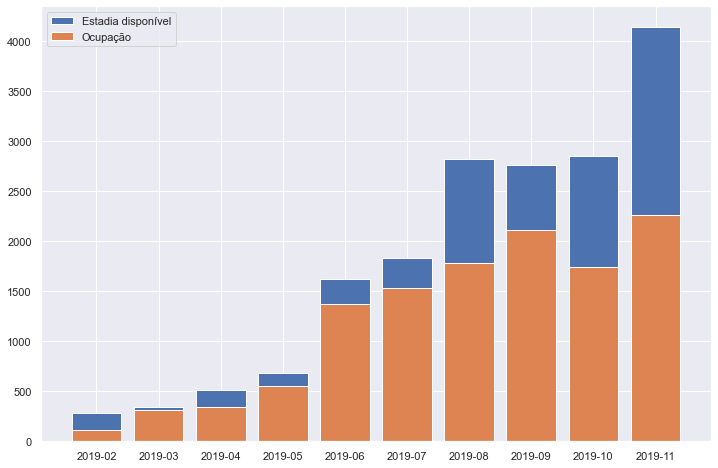

In [362]:
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(premissas.index,premissas['Estadia disponível'],label='Estadia disponível')
ax=plt.bar(premissas.index,premissas['Ocupação'], label = 'Ocupação')
plt.legend();

 * **Agora, analisaremos a variável Receita bruta estimada** 

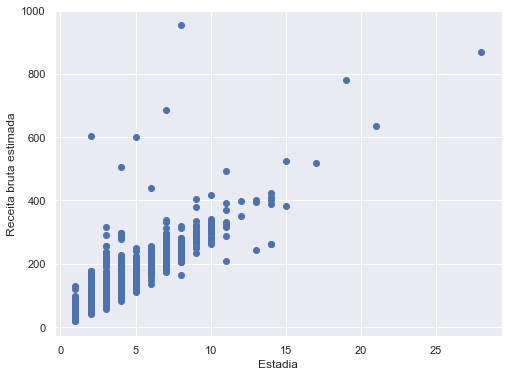

In [363]:
plt.figure(figsize=(8,6)) 
plt.scatter(df['Estadia'],df['Receita bruta estimada'])
plt.xlabel('Estadia')
plt.ylabel('Receita bruta estimada')
plt.show()

Confirmano a teoria que:  quanto maior a estadia maior receita.   

* **Agora, vamos adicionar o custo total de cada mês** 

In [364]:
premissas['Custo Total'] = premissas['Unidades disponíveis']*premissas['Custo operacional por unidade']
premissas

,Unidades disponíveis,Taxa de crescimento do custo por unidade,Custo operacional por unidade,Estadia disponível,Ocupação,Taxa de Ocupação %,Custo Total
2019-02,10,-,782.670735,280,116,41.43,7826.707350
2019-03,11,-0.05,745.400700,341,308,90.32,8199.407700
2019-04,17,-0.02,730.785000,510,344,67.45,12423.345000
2019-05,22,-0.03,709.500000,682,552,80.94,15609.000000
2019-06,54,-0.1,645.000000,1620,1371,84.63,34830.000000
2019-07,59,-0.05,612.750000,1829,1534,83.87,36152.250000
2019-08,91,-0.05,582.112500,2821,1785,63.28,52972.237500
2019-09,92,-0.01,576.291375,2760,2112,76.52,53018.806500
2019-10,92,-0.02,564.765547,2852,1739,60.97,51958.430370
2019-11,138,-0.15,480.050715,4140,2262,54.64,66246.998722


## Avaliando a saúde financeira do negócio 

Usaremos as seguintes métricas para verificar a saúde financeira do negócio:


* **Crescimento real de receita**


* **Lucro**


* **Retorno sobre investimento (ROI)**


### Crescimento real de receita

* **Receita total de cada mês**

In [365]:
Receita_Total = [df[df['Check-in'] == '2019-02']['Receita bruta estimada'].sum(),df[df['Check-in'] == '2019-03']['Receita bruta estimada'].sum(),
                  df[df['Check-in'] == '2019-04']['Receita bruta estimada'].sum(),df[df['Check-in'] == '2019-05']['Receita bruta estimada'].sum(),
                  df[df['Check-in'] == '2019-06']['Receita bruta estimada'].sum(),df[df['Check-in'] == '2019-07']['Receita bruta estimada'].sum(),
                  df[df['Check-in'] == '2019-08']['Receita bruta estimada'].sum(),df[df['Check-in'] == '2019-09']['Receita bruta estimada'].sum(),
                  df[df['Check-in'] == '2019-10']['Receita bruta estimada'].sum(),df[df['Check-in'] == '2019-11']['Receita bruta estimada'].sum()]
premissas['Receita Total'] = Receita_Total

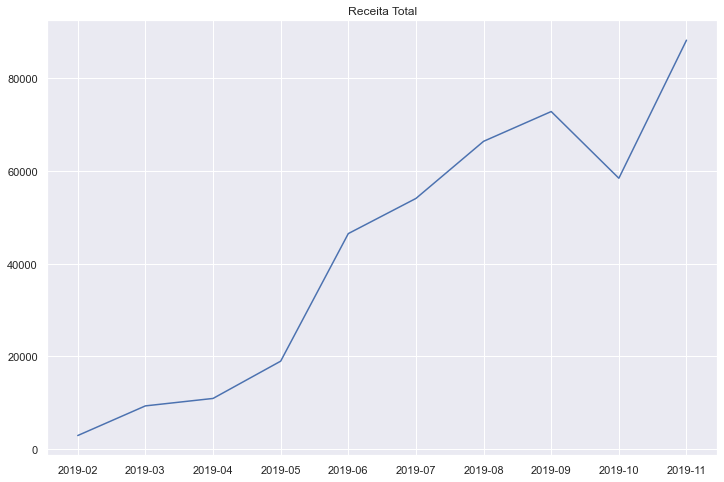

In [366]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(premissas['Receita Total'])
plt.title('Receita Total');

Podemos notar um crescimento da receita no decorrer dos meses

### Lucro

* **Lucro de cada mês**

In [367]:
premissas['Lucro'] = premissas['Receita Total']-premissas['Custo Total']
premissas[['Lucro']]

,Lucro
2019-02,-4885.686225
2019-03,1138.982550
2019-04,-1478.142375
2019-05,3378.924375
2019-06,11689.365375
2019-07,17952.643500
2019-08,13460.217750
2019-09,19837.711500
2019-10,6502.188630
2019-11,22007.819153


### Visualizando o Lucro de cada mês

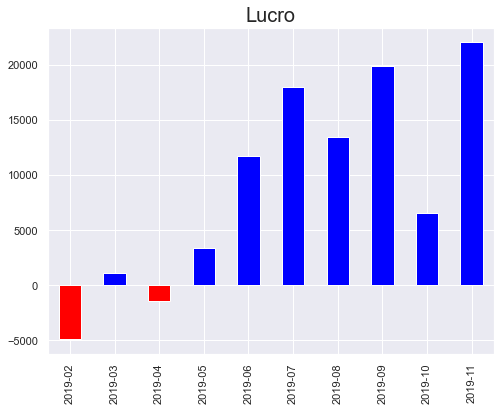

In [368]:
plt.figure(figsize=(8,6)) 
premissas['Lucro'].plot(kind='bar', color = ['red' if i<0 else 'blue' for i in premissas['Lucro']]); 
plt.title('Lucro',fontsize=20);

### Retorno sobre investimento (ROI)

In [369]:
ROI = (((premissas['Receita Total']-premissas['Custo Total'])/premissas['Custo Total'])*100).round(2)
ROI

2019-02   -62.42
2019-03    13.89
2019-04   -11.90
2019-05    21.65
2019-06    33.56
2019-07    49.66
2019-08    25.41
2019-09    37.42
2019-10    12.51
2019-11    33.22
dtype: float64

Podemos notar que os meses 02 e 04 obtiveram um ROI negativo, i.e., o investimento nestes meses fez o negócio perder dinheiro.
Contudo, nos demais meses temos o ROI positivo, ou seja, o negócio teve ganho. Podendo destacar os meses 06,07,09 e 11 os quais o negócio teve um retorno sobre o investimento de mais de 30%. 

Além disso, podemos observar que em nenhum mês, o negócio faturou acima de 50%. 

* Adicionando o volume de reservas de cada mês

In [370]:
premissas['Volume Reserva'] = df_cont['Count']

In [371]:
premissas['Volume Reserva']

2019-02     96
2019-03    104
2019-04    122
2019-05    224
2019-06    527
2019-07    517
2019-08    678
2019-09    656
2019-10    667
2019-11    682
Name: Volume Reserva, dtype: int64

In [372]:
print('Estadia disponível para 170 unidades em 12/2019:',estadia_disponivel(170,12))
print('Estadia disponível para 200 unidades em 01/2020',estadia_disponivel(200,1))

Estadia disponível para 170 unidades em 12/2019: 5270
Estadia disponível para 200 unidades em 01/2020 6200


In [373]:
premissas

,Unidades disponíveis,Taxa de crescimento do custo por unidade,Custo operacional por unidade,Estadia disponível,Ocupação,Taxa de Ocupação %,Custo Total,Receita Total,Lucro,Volume Reserva
2019-02,10,-,782.670735,280,116,41.43,7826.707350,2941.021125,-4885.686225,96
2019-03,11,-0.05,745.400700,341,308,90.32,8199.407700,9338.390250,1138.982550,104
2019-04,17,-0.02,730.785000,510,344,67.45,12423.345000,10945.202625,-1478.142375,122
2019-05,22,-0.03,709.500000,682,552,80.94,15609.000000,18987.924375,3378.924375,224
2019-06,54,-0.1,645.000000,1620,1371,84.63,34830.000000,46519.365375,11689.365375,527
2019-07,59,-0.05,612.750000,1829,1534,83.87,36152.250000,54104.893500,17952.643500,517
2019-08,91,-0.05,582.112500,2821,1785,63.28,52972.237500,66432.455250,13460.217750,678
2019-09,92,-0.01,576.291375,2760,2112,76.52,53018.806500,72856.518000,19837.711500,656
2019-10,92,-0.02,564.765547,2852,1739,60.97,51958.430370,58460.619000,6502.188630,667
2019-11,138,-0.15,480.050715,4140,2262,54.64,66246.998722,88254.817875,22007.819153,682


### O volume de Reserva de [12-2019, 12-2020] é:

In [374]:
foracasts

,Mes,reg_linear,media_movel,ARMA,ARIMA
2019-12,12-2019,868,674,620,653
2020-01,01-2020,948,668,558,628


In [375]:
foracasts.loc['2019-12','ARIMA']

653

## Variáveis Correlacionadas


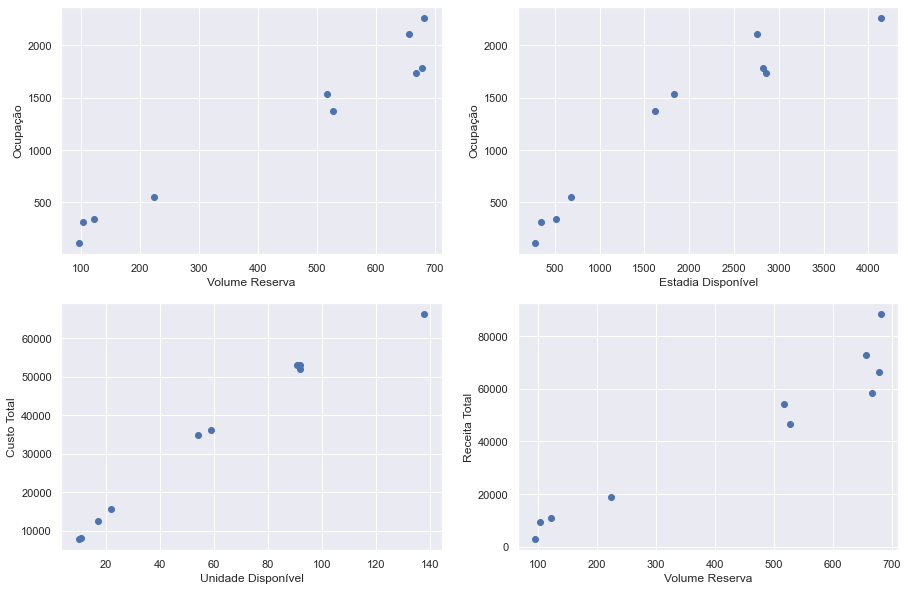

In [376]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.scatter(premissas['Volume Reserva'],premissas['Ocupação'])
#plt.title('Volume de Reserva versus Ocupação ',fontsize=10);
plt.xlabel('Volume Reserva')
plt.ylabel('Ocupação')
#plt.show()
plt.subplot(222)
plt.scatter(premissas['Estadia disponível'],premissas['Ocupação'])
#plt.title('Estadia disponível versus Ocupação',fontsize=10)
plt.xlabel('Estadia Disponível')
plt.ylabel('Ocupação')
#plt.show()
plt.subplot(223)
plt.scatter(premissas['Unidades disponíveis'],premissas['Custo Total']);
#plt.title('Unidades disponíveis versus Custo Total',fontsize=10);
plt.xlabel('Unidade Disponível')
plt.ylabel('Custo Total')
#plt.show()
plt.subplot(224)
plt.scatter(premissas['Volume Reserva'], premissas['Receita Total'])
#plt.title('Volume Reserva versus Receita Total',fontsize=10);
plt.xlabel('Volume Reserva')
plt.ylabel('Receita Total')
plt.show()

* **Regressão Linear**

In [377]:
def reg_linear(X,y):
    rl = LinearRegression()
    return rl.fit(X,y)

## Prevendo **Ocupação, Custo Total** e **Receita Total** com Regressão Linear 

* _**Volume de Reserva** utilizado será o projetado pelo o modelo de **Média Móvel**_

* Prevendo **ocupação** 

In [379]:
reg_lin_ocupacao = reg_linear(premissas[['Volume Reserva','Estadia disponível']],premissas[['Ocupação']]) 

In [380]:
ocupacao = []
ocupacao.append(reg_lin_ocupacao.predict(np.array([674,estadia_disponivel(170,12)]).reshape(1,-1)))
ocupacao.append(reg_lin_ocupacao.predict(np.array([668,estadia_disponivel(200,1)]).reshape(1,-1)))

print('Ocupação mês de 12/2019: ', float(ocupacao[0])),
print('Ocupação mês de 01/2020: ', float(ocupacao[1]))


Ocupação mês de 12/2019:  2463.7764357983688
Ocupação mês de 01/2020:  2653.5634263281227


* Prevendo **custo total** com regressão linear

In [381]:
reg_linear_CustoTotal = reg_linear(premissas[['Unidades disponíveis','Estadia disponível','Ocupação']].values,
                                   premissas[['Custo Total']])

In [382]:
CustoTotal=[]

CustoTotal.append(reg_linear_CustoTotal.predict(np.array([[170,estadia_disponivel(170,12),ocupacao[0]]])))
CustoTotal.append(reg_linear_CustoTotal.predict(np.array([[200,estadia_disponivel(200,1),ocupacao[1]]])))

print('Custo Total mês de 12/2019: ', float(CustoTotal[0])),
print('Custo Total mês de 01/2020: ', float(CustoTotal[1]));

Custo Total mês de 12/2019:  84397.32494396655
Custo Total mês de 01/2020:  96176.11861762867


C:\Users\Administrador\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

C:\Users\Administrador\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



* Prevendo **Receita Total** com regressão linear

In [383]:
reg_linear_receita_total =reg_linear(premissas[['Unidades disponíveis','Estadia disponível','Ocupação','Custo Total']].values,
                                     premissas[['Receita Total']])

In [384]:
ReceitaTotal = []
ReceitaTotal.append(reg_linear_receita_total.predict(np.array([[170,estadia_disponivel(170,12),ocupacao[0],CustoTotal[0]]])))
ReceitaTotal.append(reg_linear_receita_total.predict(np.array([[200,estadia_disponivel(200,12),ocupacao[1],CustoTotal[1]]])))


print('Ocupação mês de 12/2019: ', ReceitaTotal[0]),
print('Ocupação mês de 01/2020: ', ReceitaTotal[1]);

Ocupação mês de 12/2019:  [[95848.81847186]]
Ocupação mês de 01/2020:  [[105990.75545154]]


C:\Users\Administrador\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

C:\Users\Administrador\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



* **Lucro**

In [385]:
lucro = []
lucro.append(float(ReceitaTotal[0]-CustoTotal[0]))
lucro.append(float(ReceitaTotal[1]-CustoTotal[1]))

## Expandindo o negócio para 200 unidades em 12-2019 e 01-2020:

In [386]:
print('LUCRO', lucro)

LUCRO [11451.493527898405, 9814.63683390744]


In [387]:
col= {'Mes':['12-2019','20-2020'],'Lucro': lucro }
col


{'Mes': ['12-2019', '20-2020'],
 'Lucro': [11451.493527898405, 9814.63683390744]}

In [388]:
Lucro = pd.DataFrame(col)

In [389]:
Lucro.index = Lucro['Mes']
Lucro.drop('Mes',inplace=True,axis=1)

In [390]:
Lucro

,Lucro
Mes,
12-2019,11451.493528
20-2020,9814.636834


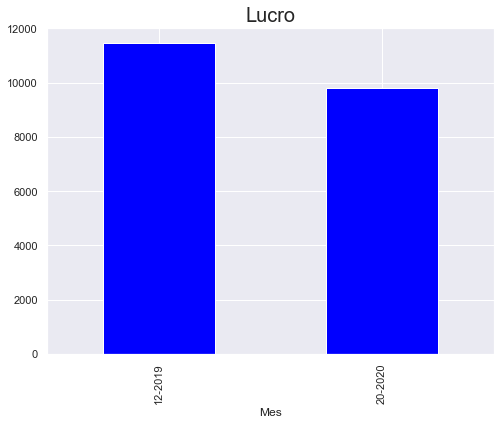

In [391]:
Lucro['Lucro'].plot(kind='bar', color = ['blue']); 
plt.title('Lucro',fontsize=20);

## Prevendo o Lucro utilizando o Volume de Reserva projetado por cada modelo

In [392]:
def ocupacao(vol_reserva,n_unid,mes):
    return reg_lin_ocupacao.predict(np.array([vol_reserva,estadia_disponivel(n_unid,mes)]).reshape(1,-1))
def custo_total(vol_reserva,n_unid,mes):
    return reg_linear_CustoTotal.predict(np.array([[n_unid,estadia_disponivel(n_unid,mes),
                                                    ocupacao(vol_reserva,n_unid,mes)]]))
def receita_total(vol_reserva,n_unid,mes):
    return reg_linear_receita_total.predict(np.array([[n_unid,estadia_disponivel(n_unid,mes), ocupacao(vol_reserva,n_unid,mes),
                                                       custo_total(vol_reserva,n_unid,mes)]]))
def lucro(vol_reserva,n_unid,mes):
    return float(receita_total(vol_reserva,n_unid,mes)-custo_total(vol_reserva,n_unid,mes))


In [393]:
lucro_cd_model = {'Mes':['12-2019','01-2020'], 
            'reg_linear':[lucro(foracasts.loc['2019-12','reg_linear'], 170,12),
                          lucro(foracasts.loc['2020-01','reg_linear'], 200,1)],
            'media_movel':[lucro(foracasts.loc['2019-12','media_movel'], 170,12),
                           lucro(foracasts.loc['2020-01','media_movel'],200,1)],
            'ARMA':[lucro(foracasts.loc['2019-12','ARMA'], 170,12),
                    lucro(foracasts.loc['2020-01','ARMA'], 200,1)],
            'ARIMA':[lucro(foracasts.loc['2019-12','ARIMA'], 170,12),
                     lucro(foracasts.loc['2020-01','ARIMA'], 200,1)]};

C:\Users\Administrador\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

C:\Users\Administrador\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

C:\Users\Administrador\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object

In [394]:
lucro_cd_model = pd.DataFrame(lucro_cd_model)
lucro_cd_model.index=['2019-12','2020-01']

* Projeção do Lucro a partir do volume de reserva projetado por cada modelo

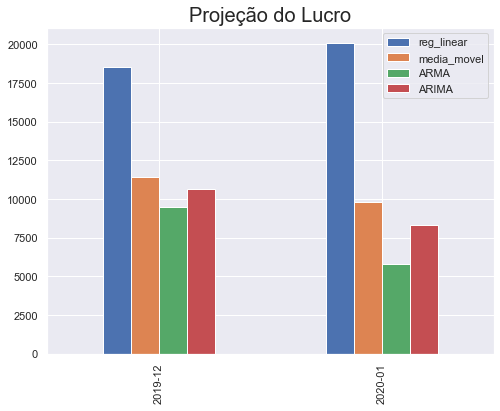

In [395]:
lucro_cd_model.plot.bar()
plt.title('Projeção do Lucro',fontsize=20)
plt.show()